# Cross check of Polarization Orientations
Its expected that the pairs PARA_0 / PERP_90 and PARA_135 / PERP_45 should produce identical amplitude analysis fits. This notebook will essentially copy-paste the methods found in `pwa_tools.Plotter`, but adapt them to overlay each orientation pair on top of each other. The same plots will also be produced but as residuals sans data. 

This particular notebook is using results from fits to the same data for the first time. It was recently found that the `PARA_0` orientation was different from the other orientations, as it was the only one that did not contain data cuts on the $p\pi^0$ mass. These fits here now all have data that does not include this cut, meaning baryonic excitations are potentially affecting fit quality at high $\omega\pi^0$ masses

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path    
import sys
parent_dir = str(Path().resolve().parents[1])
sys.path.insert(0, parent_dir)
import analysis.scripts.pwa_tools as pwa_tools

# Load and Process Data

Fit Details
* Mass binning: 1.0 -1.5, 20 MeV bins
* t bins: 0.4 -0.5 single bin
* Waveset: 1m, 1p, all m's and $\epsilon$'s

In [4]:
df1 = pd.read_csv(f"{parent_dir}/analysis/data/0-90.csv", index_col="index")
df2 = pd.read_csv(f"{parent_dir}/analysis/data/45-135.csv", index_col="index")

pwa_tools.wrap_phases(df1)
pwa_tools.wrap_phases(df2)

data_df1 = pd.read_csv(f"{parent_dir}/analysis/data/0-90_data.csv")
data_df2 = pd.read_csv(f"{parent_dir}/analysis/data/45-135_data.csv")

mass_bins = data_df1["mean"]
bin_width = (data_df1["high_edge"] - data_df1["low_edge"])[0]

coherent_sums = pwa_tools.get_coherent_sums(df1)
phase_differences = pwa_tools.get_phase_differences(df1)

mpl.rcParams['figure.dpi'] = 600 # crank up the dpi to save ~crispy~ figures

# Intensities and their Residuals

In [5]:
ms, Ls = 3, 3

fig, axs = plt.subplots(Ls, ms, sharex=True, sharey=True, figsize=(15,10))

# make a grid of JPml strings where columns are m-projs,
#   and rows are L values
JPmL_grid = np.empty(shape=(Ls, ms), dtype="<U10")
for JPmL in coherent_sums["JPmL"]:        
    grid_L_map = {"S":0, "P":1, "D":2}
    grid_m_map = {"m":0, "0":1, "p":2}        
    JPmL_grid[ grid_L_map[ JPmL[-1] ] ][ grid_m_map[ JPmL[-2] ] ] = JPmL

m_map = {"m":-1, "0":0, "p":+1}

for i in range(Ls):
    for j in range(ms):
        # get the JPmL value for this plot position
        JPmL = JPmL_grid[i,j]            
        
        if i==0:
            axs[i,j].set_title(f"m={m_map[JPmL[-2]]}",
                                fontsize=16)
        if j==0:
            axs[i,j].set_ylabel(JPmL[-1], fontsize=16)

        # plot total data for each orientation pair
        data_plot1 = axs[i,j].errorbar(
            mass_bins, data_df1["bin_contents"],
            data_df1["bin_error"], data_df1["rms"],
            marker="o", color="black", linestyle="",
            label="0/90 Data", markersize=6
        )
        data_plot2 = axs[i,j].errorbar(
            mass_bins, data_df2["bin_contents"],
            data_df2["bin_error"], data_df2["rms"],
            marker="s", color="black", linestyle="",
            label="45/135 Data", markersize=6
        )


        # plot the reflectivity contributions
        neg_refl1     = df1["m"+JPmL]
        neg_refl1_err = df1["m"+JPmL+"_err"]
        pos_refl1     = df1["p"+JPmL]
        pos_refl1_err = df1["p"+JPmL+"_err"]

        neg_refl2     = df2["m"+JPmL]
        neg_refl2_err = df2["m"+JPmL+"_err"]
        pos_refl2     = df2["p"+JPmL]
        pos_refl2_err = df2["p"+JPmL+"_err"]

        neg_plot1 = axs[i,j].errorbar(
            mass_bins, neg_refl1, 
            neg_refl1_err, bin_width/2,
            "o", color="darkblue", markersize=4,
            label=r"0/90 $\epsilon=-1$"
        )
        pos_plot1 = axs[i,j].errorbar(
            mass_bins, pos_refl1, 
            pos_refl1_err, bin_width/2,
            "o", color="orangered", markersize=4,
            label=r"0/90 $\epsilon=+1$"
        )

        neg_plot2 = axs[i,j].errorbar(
            mass_bins, neg_refl2, 
            neg_refl2_err, bin_width/2,
            "s", color="cornflowerblue", markersize=4,
            label=r"45/135 $\epsilon=-1$"
        )
        pos_plot2 = axs[i,j].errorbar(
            mass_bins, pos_refl2, 
            pos_refl2_err, bin_width/2,
            "s", color="lightcoral", markersize=4,
            label=r"45/135 $\epsilon=+1$"
        )
        
        # must be set AFTER data is plotted
        axs[i,j].set_ylim(bottom=0)


# plot grids
for ax in axs.reshape(-1):
    ax.grid(True, axis="y", alpha=0.8)

# figure cosmetics
fig.text(0.5, 0.04, r"$\omega\pi^0$ inv. mass $(GeV)$", ha="center", fontsize=15)
fig.text(0.04, 0.5, f"Events / {int(bin_width*1000)} MeV", ha="center", fontsize=15, rotation="vertical")

fig.legend( 
    handles=[data_plot1, data_plot2, pos_plot1, neg_plot1, pos_plot2, neg_plot2],
    fontsize=12, loc="upper right", ncols=2
) 

# show and save figure
plt.show()

That already looks so much better than before, things are matching up quite well in each reflectivity between the orientation pairs. Lets look at three different plots to better understand whats going on:
1. The fit fractions, to avoid any slight differences in the amount of data bin to bin
2. The fit fractions residuals, to better find any discrepancies
3. Those same residuals scaled by their error to get a little better sense of how the error factors in

In [6]:
ms, Ls = 3, 3
fig, axs = plt.subplots(Ls, ms, sharex=True, sharey=True,
                        figsize=(15,10))
# make a grid of JPml strings where columns are m-projs,
#   and rows are L values
JPmL_grid = np.empty(shape=(Ls, ms), dtype="<U10")
for JPmL in coherent_sums["JPmL"]:        
    grid_L_map = {"S":0, "P":1, "D":2}
    grid_m_map = {"m":0, "0":1, "p":2}        
    JPmL_grid[grid_L_map[JPmL[-1]]][grid_m_map[JPmL[-2]]] = JPmL

m_map = {"m":-1, "0":0, "p":+1}

fit_result1 = data_df1["bin_contents"]
fit_result2 = data_df2["bin_contents"]

for i in range(Ls):
    for j in range(ms):
        # get the JPmL value for this plot position
        JPmL = JPmL_grid[i,j]            
        
        if i==0:
            axs[i,j].set_title(f"m={m_map[JPmL[-2]]}",
                                fontsize=16)
        if j==0:
            axs[i,j].set_ylabel(JPmL[-1], fontsize=16)

        # plot the reflectivity contributions
        neg_refl1     = df1["m"+JPmL] / fit_result1
        neg_refl1_err = neg_refl1 * np.sqrt(np.square(df1["m"+JPmL+"_err"]/df1["m"+JPmL]) 
                                            + np.square(data_df1["bin_error"]/fit_result1))
        pos_refl1     = df1["p"+JPmL] / fit_result1
        pos_refl1_err = pos_refl1 * np.sqrt(np.square(df1["p"+JPmL+"_err"]/df1["p"+JPmL]) 
                                            + np.square(data_df1["bin_error"]/fit_result1))

        neg_refl2     = df2["m"+JPmL] / fit_result2
        neg_refl2_err = neg_refl2 * np.sqrt(np.square(df2["m"+JPmL+"_err"]/df2["m"+JPmL]) 
                                            + np.square(data_df2["bin_error"]/fit_result2))
        pos_refl2     = df2["p"+JPmL] / fit_result2
        pos_refl2_err = pos_refl2 * np.sqrt(np.square(df2["p"+JPmL+"_err"]/df2["p"+JPmL]) 
                                            + np.square(data_df2["bin_error"]/fit_result2))

        neg_plot1 = axs[i,j].errorbar(
            mass_bins, neg_refl1, 
            neg_refl1_err, bin_width/2,
            "o", color="darkblue", markersize=6,
            label=r"0/90 $\epsilon=-1$"
        )
        neg_plot2 = axs[i,j].errorbar(
            mass_bins, neg_refl2, 
            neg_refl2_err, bin_width/2,
            "s", color="cornflowerblue", markersize=6,
            label=r"45/135 $\epsilon=-1$"
        )
        pos_plot1 = axs[i,j].errorbar(
            mass_bins, pos_refl1, 
            pos_refl1_err, bin_width/2,
            "o", color="orangered", markersize=6,
            label=r"0/90 $\epsilon=+1$"
        )
        pos_plot2 = axs[i,j].errorbar(
            mass_bins, pos_refl2, 
            pos_refl2_err, bin_width/2,
            "s", color="lightcoral", markersize=6,
            label=r"45/135 $\epsilon=+1$"
        )

        # must be set AFTER data is plotted                
        axs[i,j].set_ylim(0, 1.0)


# plot grids
for ax in axs.reshape(-1):
    ax.grid(True, axis="y", alpha=0.8)

# figure cosmetics
fig.text(0.5, 0.04, r"$\omega\pi^0$ invariant mass (GeV)", ha="center", fontsize=15)
fig.text(0.04, 0.5, rf"Fit Fractions / {int(bin_width*1000)} MeV", ha="center", fontsize=15, rotation="vertical")

fig.legend( 
    handles=[pos_plot1, neg_plot1, pos_plot2, neg_plot2],
    fontsize=12, loc="upper right"
) 

plt.show()

In [7]:
# same deal for setting up the figure
ms, Ls = 3, 3
fig, axs = plt.subplots(Ls, ms, sharex=True, sharey=True,
                        figsize=(15,10))
# make a grid of JPml strings where columns are m-projs,
#   and rows are L values
JPmL_grid = np.empty(shape=(Ls, ms), dtype="<U10")
for JPmL in coherent_sums["JPmL"]:        
    grid_L_map = {"S":0, "P":1, "D":2}
    grid_m_map = {"m":0, "0":1, "p":2}        
    JPmL_grid[grid_L_map[JPmL[-1]]][grid_m_map[JPmL[-2]]] = JPmL

m_map = {"m":-1, "0":0, "p":+1}

fit_result1 = data_df1["bin_contents"]
fit_result2 = data_df2["bin_contents"]

for i in range(Ls):
    for j in range(ms):
        # get the JPmL value for this plot position
        JPmL = JPmL_grid[i,j]            
        
        if i==0:
            axs[i,j].set_title(f"m={m_map[JPmL[-2]]}",
                                fontsize=16)
        if j==0:
            axs[i,j].set_ylabel(JPmL[-1], fontsize=16)

        # plot the reflectivity contributions
        neg_refl1     = df1["m"+JPmL] / fit_result1
        neg_refl1_err = neg_refl1 * np.sqrt(np.square(df1["m"+JPmL+"_err"]/df1["m"+JPmL]) 
                                            + np.square(data_df1["bin_error"]/fit_result1))
        pos_refl1     = df1["p"+JPmL] / fit_result1
        pos_refl1_err = pos_refl1 * np.sqrt(np.square(df1["p"+JPmL+"_err"]/df1["p"+JPmL]) 
                                            + np.square(data_df1["bin_error"]/fit_result1))

        neg_refl2     = df2["m"+JPmL] / fit_result2
        neg_refl2_err = neg_refl2 * np.sqrt(np.square(df2["m"+JPmL+"_err"]/df2["m"+JPmL]) 
                                            + np.square(data_df2["bin_error"]/fit_result2))
        pos_refl2     = df2["p"+JPmL] / fit_result2
        pos_refl2_err = pos_refl2 * np.sqrt(np.square(df2["p"+JPmL+"_err"]/df2["p"+JPmL]) 
                                            + np.square(data_df2["bin_error"]/fit_result2))

        neg_plot = axs[i,j].errorbar(
            mass_bins, neg_refl1 - neg_refl2, 
            np.sqrt(np.square(neg_refl1_err) + np.square(neg_refl2_err)), bin_width/2,
            ".", color="blue", markersize=4,
            label=r"(0/90 - 45/135) $\epsilon=-1$"
        )
        pos_plot = axs[i,j].errorbar(
            mass_bins, pos_refl1 - pos_refl2, 
            np.sqrt(np.square(pos_refl1_err) + np.square(pos_refl2_err)), bin_width/2,
            ".", color="red", markersize=4,
            label=r"(0/90 - 45/135) $\epsilon=+1$"
        )

        # must be set AFTER data is plotted    
        axs[i,j].set_ylim(-0.2, 0.2)


# plot grids
for ax in axs.reshape(-1):
    ax.grid(True, axis="y", alpha=0.8)

# figure cosmetics
fig.text(0.5, 0.04, r"$\omega\pi^0$ invariant mass (GeV)", ha="center", fontsize=15)
fig.text(0.04, 0.5, rf"$\Delta$ Fit Fraction / {int(bin_width*1000)} MeV", ha="center", fontsize=15, rotation="vertical")

fig.legend( 
    handles=[pos_plot, neg_plot],
    fontsize=12, loc="upper right"
) 

plt.show()




In [8]:
# now do the error scaled plot
ms, Ls = 3, 3
fig, axs = plt.subplots(Ls, ms, sharex=True, sharey=True,
                        figsize=(15,10))

JPmL_grid = np.empty(shape=(Ls, ms), dtype="<U10")
for JPmL in coherent_sums["JPmL"]:        
    grid_L_map = {"S":0, "P":1, "D":2}
    grid_m_map = {"m":0, "0":1, "p":2}        
    JPmL_grid[grid_L_map[JPmL[-1]]][grid_m_map[JPmL[-2]]] = JPmL

m_map = {"m":-1, "0":0, "p":+1}

fit_result1 = data_df1["bin_contents"]
fit_result2 = data_df2["bin_contents"]

for i in range(Ls):
    for j in range(ms):
        # get the JPmL value for this plot position
        JPmL = JPmL_grid[i,j]            
        
        if i==0:
            axs[i,j].set_title(f"m={m_map[JPmL[-2]]}",
                                fontsize=16)
        if j==0:
            axs[i,j].set_ylabel(JPmL[-1], fontsize=16)

        # plot the reflectivity contributions
        neg_refl1     = df1["m"+JPmL] / fit_result1
        neg_refl1_err = neg_refl1 * np.sqrt(np.square(df1["m"+JPmL+"_err"]/df1["m"+JPmL]) 
                                            + np.square(data_df1["bin_error"]/fit_result1))
        pos_refl1     = df1["p"+JPmL] / fit_result1
        pos_refl1_err = pos_refl1 * np.sqrt(np.square(df1["p"+JPmL+"_err"]/df1["p"+JPmL]) 
                                            + np.square(data_df1["bin_error"]/fit_result1))

        neg_refl2     = df2["m"+JPmL] / fit_result2
        neg_refl2_err = neg_refl2 * np.sqrt(np.square(df2["m"+JPmL+"_err"]/df2["m"+JPmL]) 
                                            + np.square(data_df2["bin_error"]/fit_result2))
        pos_refl2     = df2["p"+JPmL] / fit_result2
        pos_refl2_err = pos_refl2 * np.sqrt(np.square(df2["p"+JPmL+"_err"]/df2["p"+JPmL]) 
                                            + np.square(data_df2["bin_error"]/fit_result2))

        neg_plot = axs[i,j].errorbar(
            mass_bins, (neg_refl1 - neg_refl2) /  np.sqrt(np.square(neg_refl1_err) + np.square(neg_refl2_err)),
            0, bin_width/2,
            ".", color="blue", markersize=4,
            label=r"(0/90 - 45/135) $\epsilon=-1$"
        )
        pos_plot = axs[i,j].errorbar(
            mass_bins, (pos_refl1 - pos_refl2) / np.sqrt(np.square(pos_refl1_err) + np.square(pos_refl2_err)), 
            0, bin_width/2,
            ".", color="red", markersize=4,
            label=r"(0/90 - 45/135) $\epsilon=+1$"
        )

        # must be set AFTER data is plotted    
        axs[i,j].set_ylim(-5.0, 5.0)


# plot grids
for ax in axs.reshape(-1):
    ax.grid(True, axis="y", alpha=0.8)

# figure cosmetics
fig.text(0.5, 0.04, r"$\omega\pi^0$ invariant mass (GeV)", ha="center", fontsize=15)
fig.text(0.04, 0.5, rf"($\Delta$ Fit Fraction / $\sigma$) / {int(bin_width*1000)} MeV", ha="center", fontsize=15, rotation="vertical")

fig.legend( 
    handles=[pos_plot, neg_plot],
    fontsize=12, loc="upper right"
) 

plt.show()


# Phase Difference
Okay now lets check on the $S_0^+ - P_1^+$ phase difference. As a reminder, mass dependent studies showed this phase difference is between the 2 amplitudes that should capture a $b_1$ resonance $(S_0^+)$ and an excited $\rho$ resonance $(P_1^+)$.

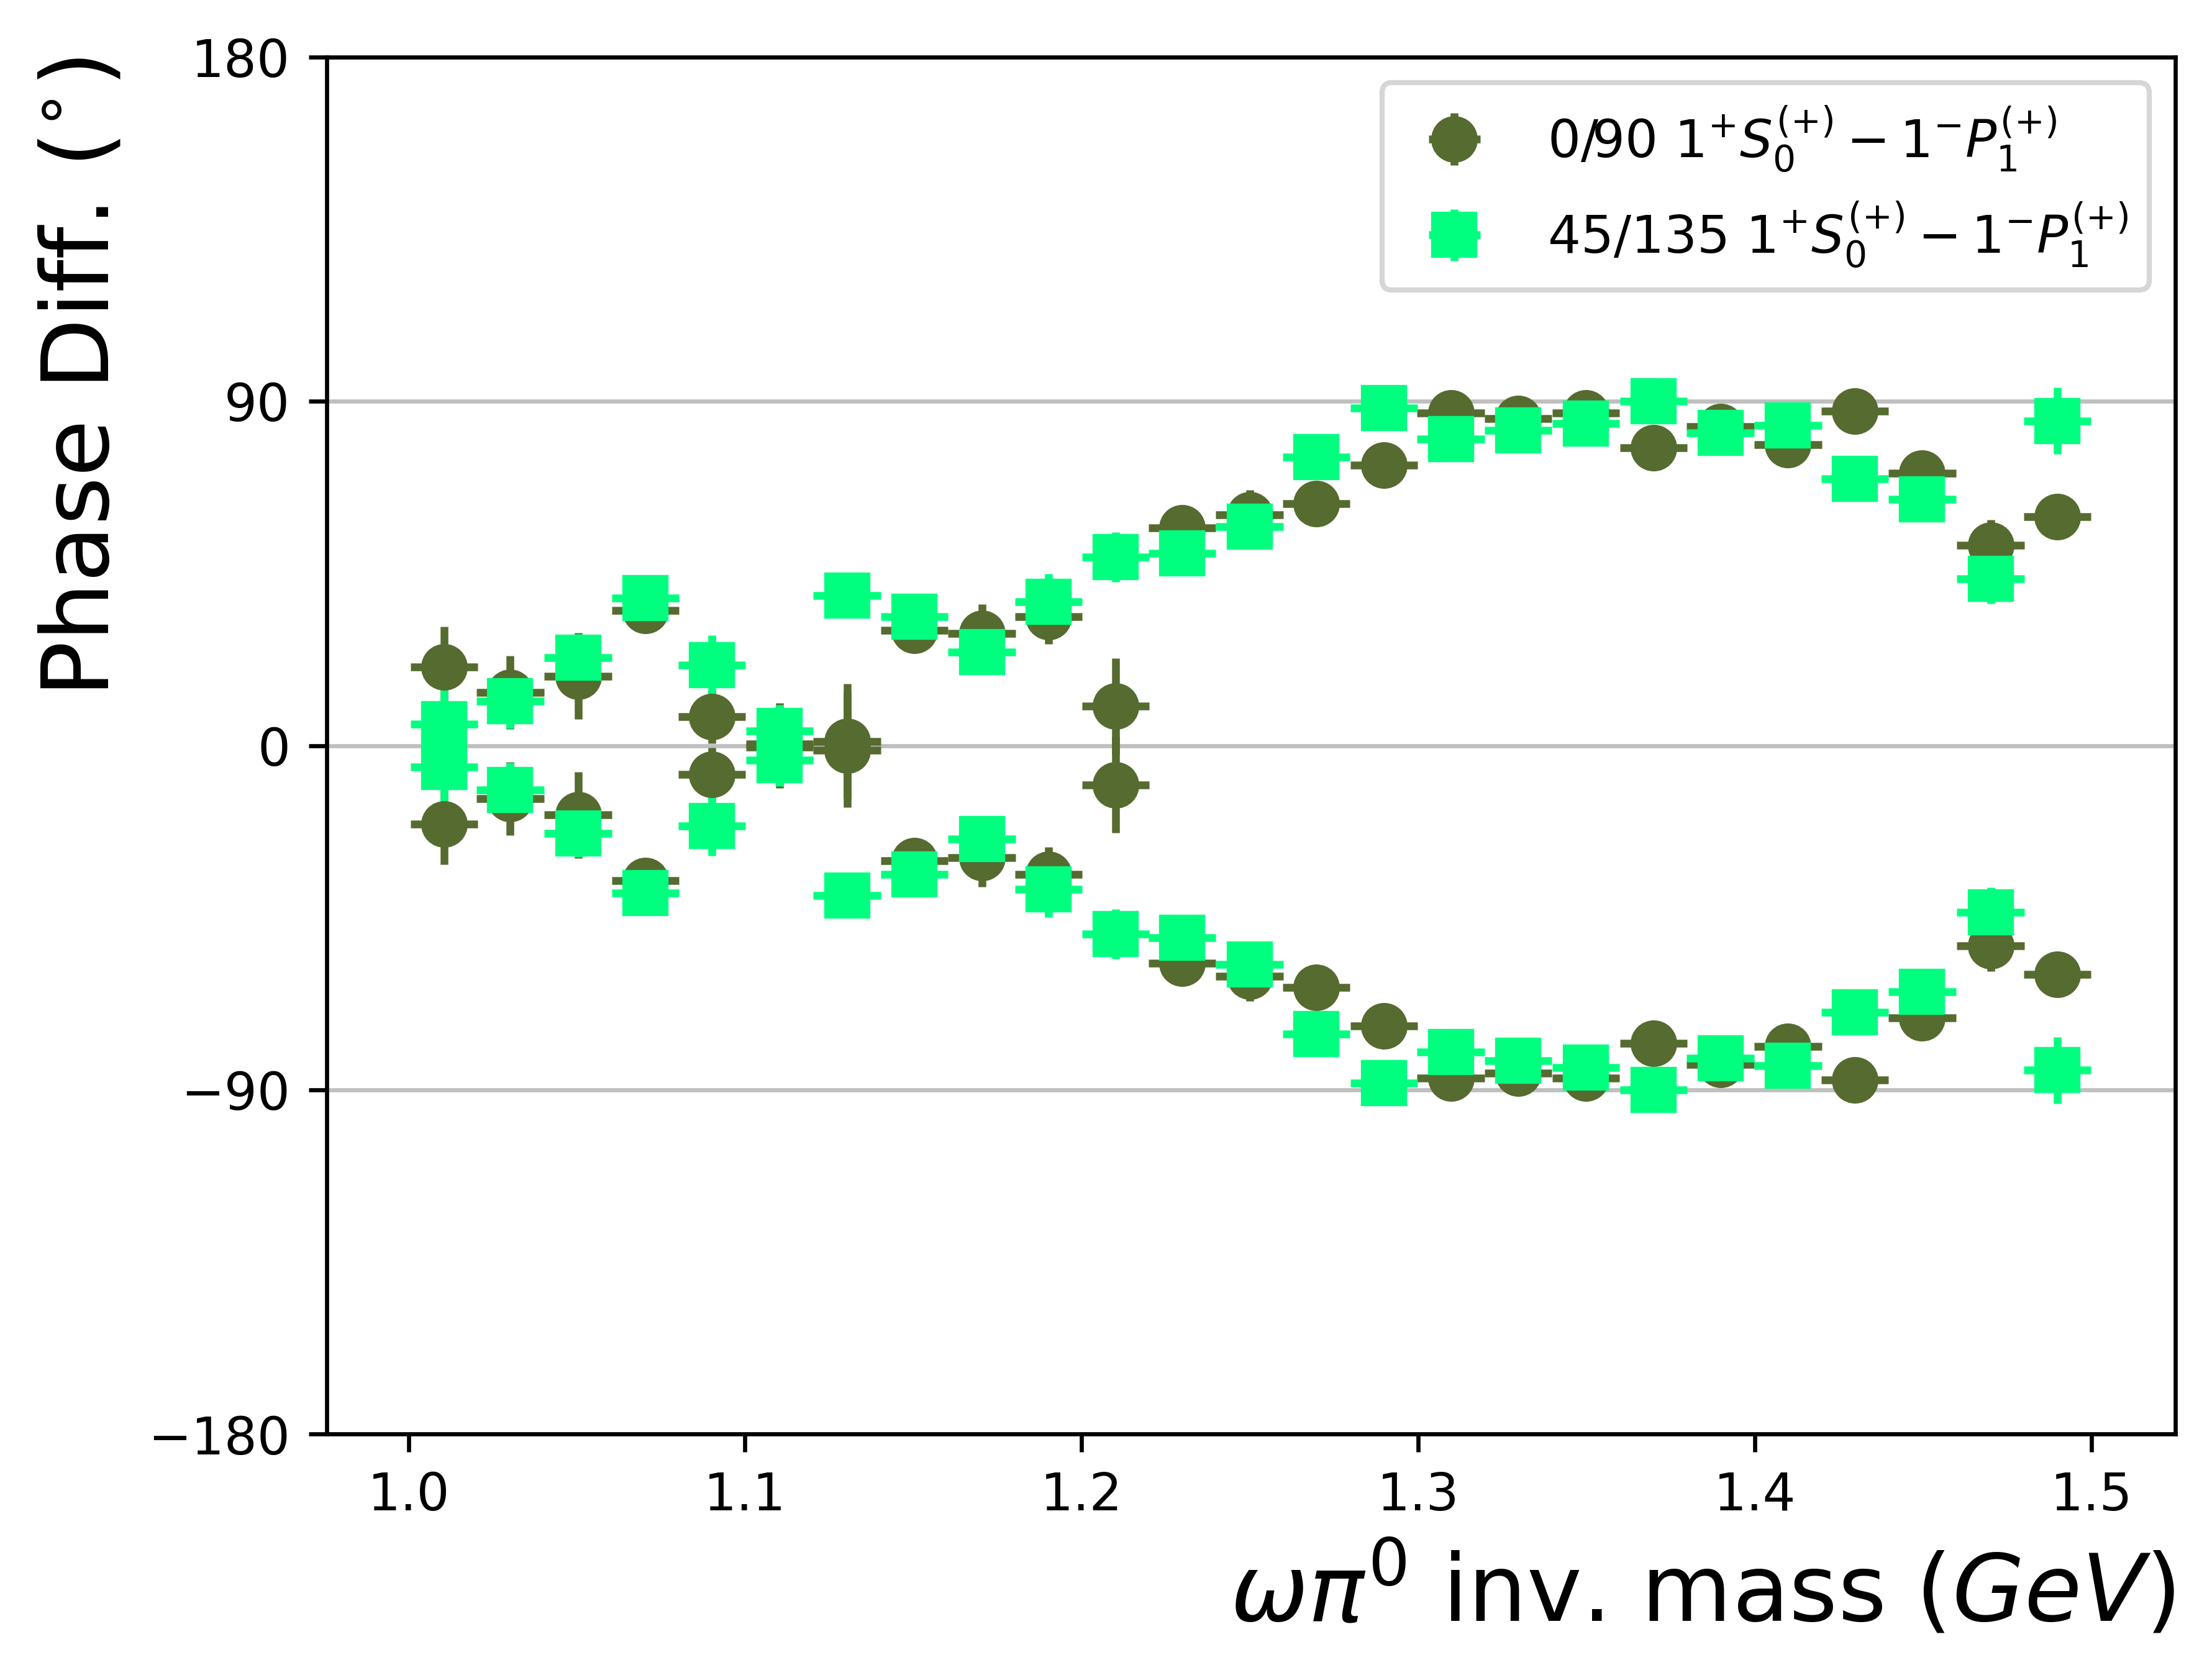

In [12]:
phase_dif = phase_differences[("p1p0S", "p1mpP")]
fig, ax = plt.subplots()
# 0/90
ax.errorbar(
    mass_bins,
    df1[phase_dif].apply(np.rad2deg),
    df1[phase_dif+"_err"].abs().apply(np.rad2deg),
    bin_width/2,
    linestyle="", color="darkolivegreen", marker="o", markersize=8
)
ax.errorbar(
    mass_bins,
    -df1[phase_dif].apply(np.rad2deg),
    df1[phase_dif+"_err"].abs().apply(np.rad2deg),
    bin_width/2, label=f"0/90 {pwa_tools.convert_amp_name(phase_dif)}",
    linestyle="", color="darkolivegreen", marker="o", markersize=8
)
# 45/135
ax.errorbar(
    mass_bins,
    df2[phase_dif].apply(np.rad2deg),
    df2[phase_dif+"_err"].abs().apply(np.rad2deg),
    bin_width/2, label=f"45/135 {pwa_tools.convert_amp_name(phase_dif)}",
    linestyle="", color="springgreen", marker="s", markersize=8
)
ax.errorbar(
    mass_bins,
    -df2[phase_dif].apply(np.rad2deg),
    df2[phase_dif+"_err"].abs().apply(np.rad2deg),
    bin_width/2,
    linestyle="", color="springgreen", marker="s", markersize=8
)

ax.grid(True, axis="y", alpha=0.8)
ax.legend()

ax.set_yticks(np.linspace(-180,180,5))
ax.set_ylim([-180, 180])
ax.set_ylabel(r"Phase Diff. ($^{\circ}$)", loc="top", fontsize=18)
ax.set_xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$", loc="right", fontsize=18)

plt.show()

# Cross Section
Lastly lets check what the cross section looks like. We'll need to load in the csv that is binned in t